In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
import pandas as pd
from scipy.stats import pearsonr
import os
import sys
import shapely.geometry as sgeom
from shapely.prepared import prep
from shapely.geometry import box
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
from shapely.ops import unary_union
# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open SST data
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

In [3]:
# Fill SST
sst_fill = xr.where(sst < -1.8, -1.8, sst)

In [4]:
# Open convective weather environment data
cape  = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
s06   = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']
ndsev = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__']

In [5]:
# Subset conus
s06_conus = s06.sel(latitude=slice(49, 24)).sel(longitude=slice(235, 294))

In [6]:
# Change the shape of CAPE data
cape_stack = cape.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_stack['time'].get_index('time').get_level_values('year')
date = cape_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_stack = cape_stack.assign_coords(time=datetime)

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/xarray/core/dataset.py:5195: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})
/tmp/ipykernel_4202/1241373606.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_stack = ca

In [7]:
# Select 1940-2024
cape_1940_2024 = cape_stack.sel(time=cape_stack.time.dt.year.isin(np.arange(1940, 2025, 1)))
s06_1940_2024  = s06_conus.sel(time=s06_conus.time.dt.year.isin(np.arange(1940, 2025, 1)))

# Select March, April and May
cape_1940_2024_mam = cape_1940_2024.sel(time=cape_1940_2024.time.dt.month.isin([3, 4, 5])).dropna(dim='time')
s06_1940_2024_mam = s06_1940_2024.sel(time=s06_1940_2024.time.dt.month.isin([3, 4, 5])).dropna(dim='time')
ndsev_1940_2024_mam = ndsev

In [8]:
# Take MAM mean for CAPE and S06 
cape_1940_2024_mam_mean = cape_1940_2024_mam.resample(time='YE').mean().load()
s06_1940_2024_mam_mean = s06_1940_2024_mam.resample(time='YE').mean().load()

In [9]:
# Compute NDSEV during MAM
ndsev_monthly = np.zeros((85, 101, 237))
for i in range(85):
    ndsev_monthly[i] = ndsev_1940_2024_mam.isel(time=slice(i*92, (i+1)*92)).transpose('time', 'latitude', 'longitude').values.sum(axis=0)

In [10]:
# Convert ndsev to xr
ndsev_1940_2024_mam_count = xr.DataArray(ndsev_monthly.swapaxes(0, 2).swapaxes(0, 1), coords={'latitude':ndsev['latitude'], 'longitude':ndsev['longitude'], 'time':cape_1940_2024_mam_mean['time']}, \
                                         dims=['latitude', 'longitude', 'time'])

In [11]:
# Subset the eastern US
cape_east = cape_1940_2024_mam_mean.sel(longitude=slice(pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82))).sel(latitude=slice(47, 30))
s06_east = s06_1940_2024_mam_mean.sel(longitude=slice(pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82))).sel(latitude=slice(47, 30))
ndsev_east = ndsev_1940_2024_mam_count.sel(longitude=slice(pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82))).sel(latitude=slice(47, 30))

In [12]:
# Land mask
land_mask = regionmask.defined_regions.natural_earth_v4_1_0.land_110.mask(cape_east)

east_land = xr.where(land_mask == 0, 1, np.nan)

cape_east_land = cape_east*east_land

In [13]:
# Area averaging
weights = np.cos(np.deg2rad(cape_east.latitude))

cape_east_mean = cape_east.weighted(weights).mean(dim=('latitude', 'longitude'))
s06_east_mean = s06_east.weighted(weights).mean(dim=('latitude', 'longitude'))
ndsev_east_mean = ndsev_east.weighted(weights).mean(dim=('latitude', 'longitude'))

In [14]:
# Detrend
cape_east_mean_de = pdo_functions.detrend_dim(cape_east_mean, 'time', 2)
s06_east_mean_de = pdo_functions.detrend_dim(s06_east_mean, 'time', 2)
ndsev_east_mean_de = pdo_functions.detrend_dim(ndsev_east_mean, 'time', 2)

In [15]:
# Subset 1940-2024 SST
sst_1940_2024 = sst_fill.sel(time=sst_fill.time.dt.year.isin(np.arange(1940, 2025, 1)))
sst_1940_2024_mam = sst_1940_2024.sel(time=sst_1940_2024.time.dt.month.isin([3, 4, 5]))

# Take the seasonal mean
sst_1940_2024_mam_mean = sst_1940_2024_mam.resample(time='YE').mean()

In [16]:
# Detrend SSTs
sst_de = pdo_functions.detrend_dim(sst_1940_2024_mam_mean, 'time', 2)

In [17]:
# standardize everything
cape_east_mean_de_std = (cape_east_mean_de - cape_east_mean_de.mean(dim='time')) / cape_east_mean_de.std(dim='time')
s06_east_mean_de_std = (s06_east_mean_de - s06_east_mean_de.mean(dim='time')) / s06_east_mean_de.std(dim='time')
ndsev_east_mean_de_std = (ndsev_east_mean_de - ndsev_east_mean_de.mean(dim='time')) / ndsev_east_mean_de.std(dim='time')

sst_de_std = (sst_de - sst_de.mean(dim='time')) / sst_de.std(dim='time')

In [21]:
# Correlate SSTs with convective weather environments
cape_corr = xr.corr(sst_de, cape_east_mean_de, dim='time')
s06_corr = xr.corr(sst_de, s06_east_mean_de, dim='time')
ndsev_corr = xr.corr(sst_de, ndsev_east_mean_de, dim='time')

In [25]:
cape_east_mean_de

<xarray.DataArray (time: 85)> Size: 680B
array([ -82.29216313, -117.20588279,  -41.13072809,  -11.04921193,
        111.99803403,   42.09198668,  -17.45820154,  -39.79112265,
         28.72170524,  104.67530596,   66.10216997,  -49.70315088,
        -76.11677401,   82.13562155,   19.48439336,   90.88594924,
          5.3138509 ,   76.89135424,  -44.27609637,   41.86000087,
        -24.14570495,  -65.73536547,   44.40584806,   27.72792924,
         26.26562956,   56.55966923,  -56.2142311 ,  -31.86739614,
        -45.10181882,  -70.90383143,   -5.85624288, -102.25116766,
        -22.95316911,  -46.67959385,   63.32490298,   89.64000217,
        -64.88695348,   70.88269887,    8.76682005,  -49.4101772 ,
        -37.7239216 ,  -16.88969067,   66.77424812, -112.24736961,
        -19.68589457,   34.98481394,   12.07915556,   42.26507357,
       -107.95029757,   80.18386566,   20.14907614,  208.83981668,
        -60.04998781, -102.73628216,  -30.9861143 ,   -0.57893938,
         49.1478277 ,  -94.36548201,   86.46444764,   13.01426504,
         34.42267369,    7.86068295,   35.94494122,   -2.55685968,
         23.33637838, -106.77988805,   33.80249876,  -43.57586536,
        -56.20319227,  -48.81636482,  -23.25267477,   94.42865428,
        129.62872402,  -48.50518278,  -91.09078149,    2.20343437,
        -21.43696455,   45.80068028,   26.27249239,    3.01117649,
        -51.869251  , -110.43669897,   89.83602374,  -36.18142251,
         90.76328659])
Coordinates:
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

In [24]:
sst_de

<xarray.DataArray (time: 85, latitude: 180, longitude: 360)> Size: 44MB
array([[[ 1.77635684e-15,  1.77635684e-15,  1.77635684e-15, ...,
          1.77635684e-15,  1.77635684e-15,  1.77635684e-15],
        [ 1.77635684e-15,  1.77635684e-15,  1.77635684e-15, ...,
          1.77635684e-15,  1.77635684e-15,  1.77635684e-15],
        [ 1.77635684e-15,  1.77635684e-15,  1.77635684e-15, ...,
          1.77635684e-15,  1.77635684e-15,  1.77635684e-15],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 1.77635684e-15,  1.77635684e-15,  1.77635684e-15, ...,
          1.77635684e-15,  1.77635684e-15,  1.77635684e-15],
        [ 1.77635684e-15,  1.77635684e-15,  1.77635684e-15, ...,
          1.77635684e-15,  1.77635684e-15,  1.77635684e-15],
        [ 1.77635684e-15,  1.77635684e-15,  1.77635684e-15, ...,
          1.77635684e-15,  1.77635684e-15,  1.77635684e-15],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-8.88178420e-16, -8.88178420e-16, -8.88178420e-16, ...,
         -8.88178420e-16, -8.88178420e-16, -8.88178420e-16],
        [-8.88178420e-16, -8.88178420e-16, -8.88178420e-16, ...,
         -8.88178420e-16, -8.88178420e-16, -8.88178420e-16],
        [-8.88178420e-16, -8.88178420e-16, -8.88178420e-16, ...,
         -8.88178420e-16, -8.88178420e-16, -8.88178420e-16],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time       (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

In [22]:
# Select domain
cape_corr_sel = cape_corr.sel(latitude=slice(70, -70)).sel(longitude=slice(115, 180))
cape_corr_sel1 = cape_corr.sel(latitude=slice(70, -70)).sel(longitude=slice(-180, -65))

s06_corr_sel = s06_corr.sel(latitude=slice(70, -70)).sel(longitude=slice(115, 180))
s06_corr_sel1 = s06_corr.sel(latitude=slice(70, -70)).sel(longitude=slice(-180, -65))

ndsev_corr_sel = ndsev_corr.sel(latitude=slice(70, -70)).sel(longitude=slice(115, 180))
ndsev_corr_sel1 = ndsev_corr.sel(latitude=slice(70, -70)).sel(longitude=slice(-180, -65))

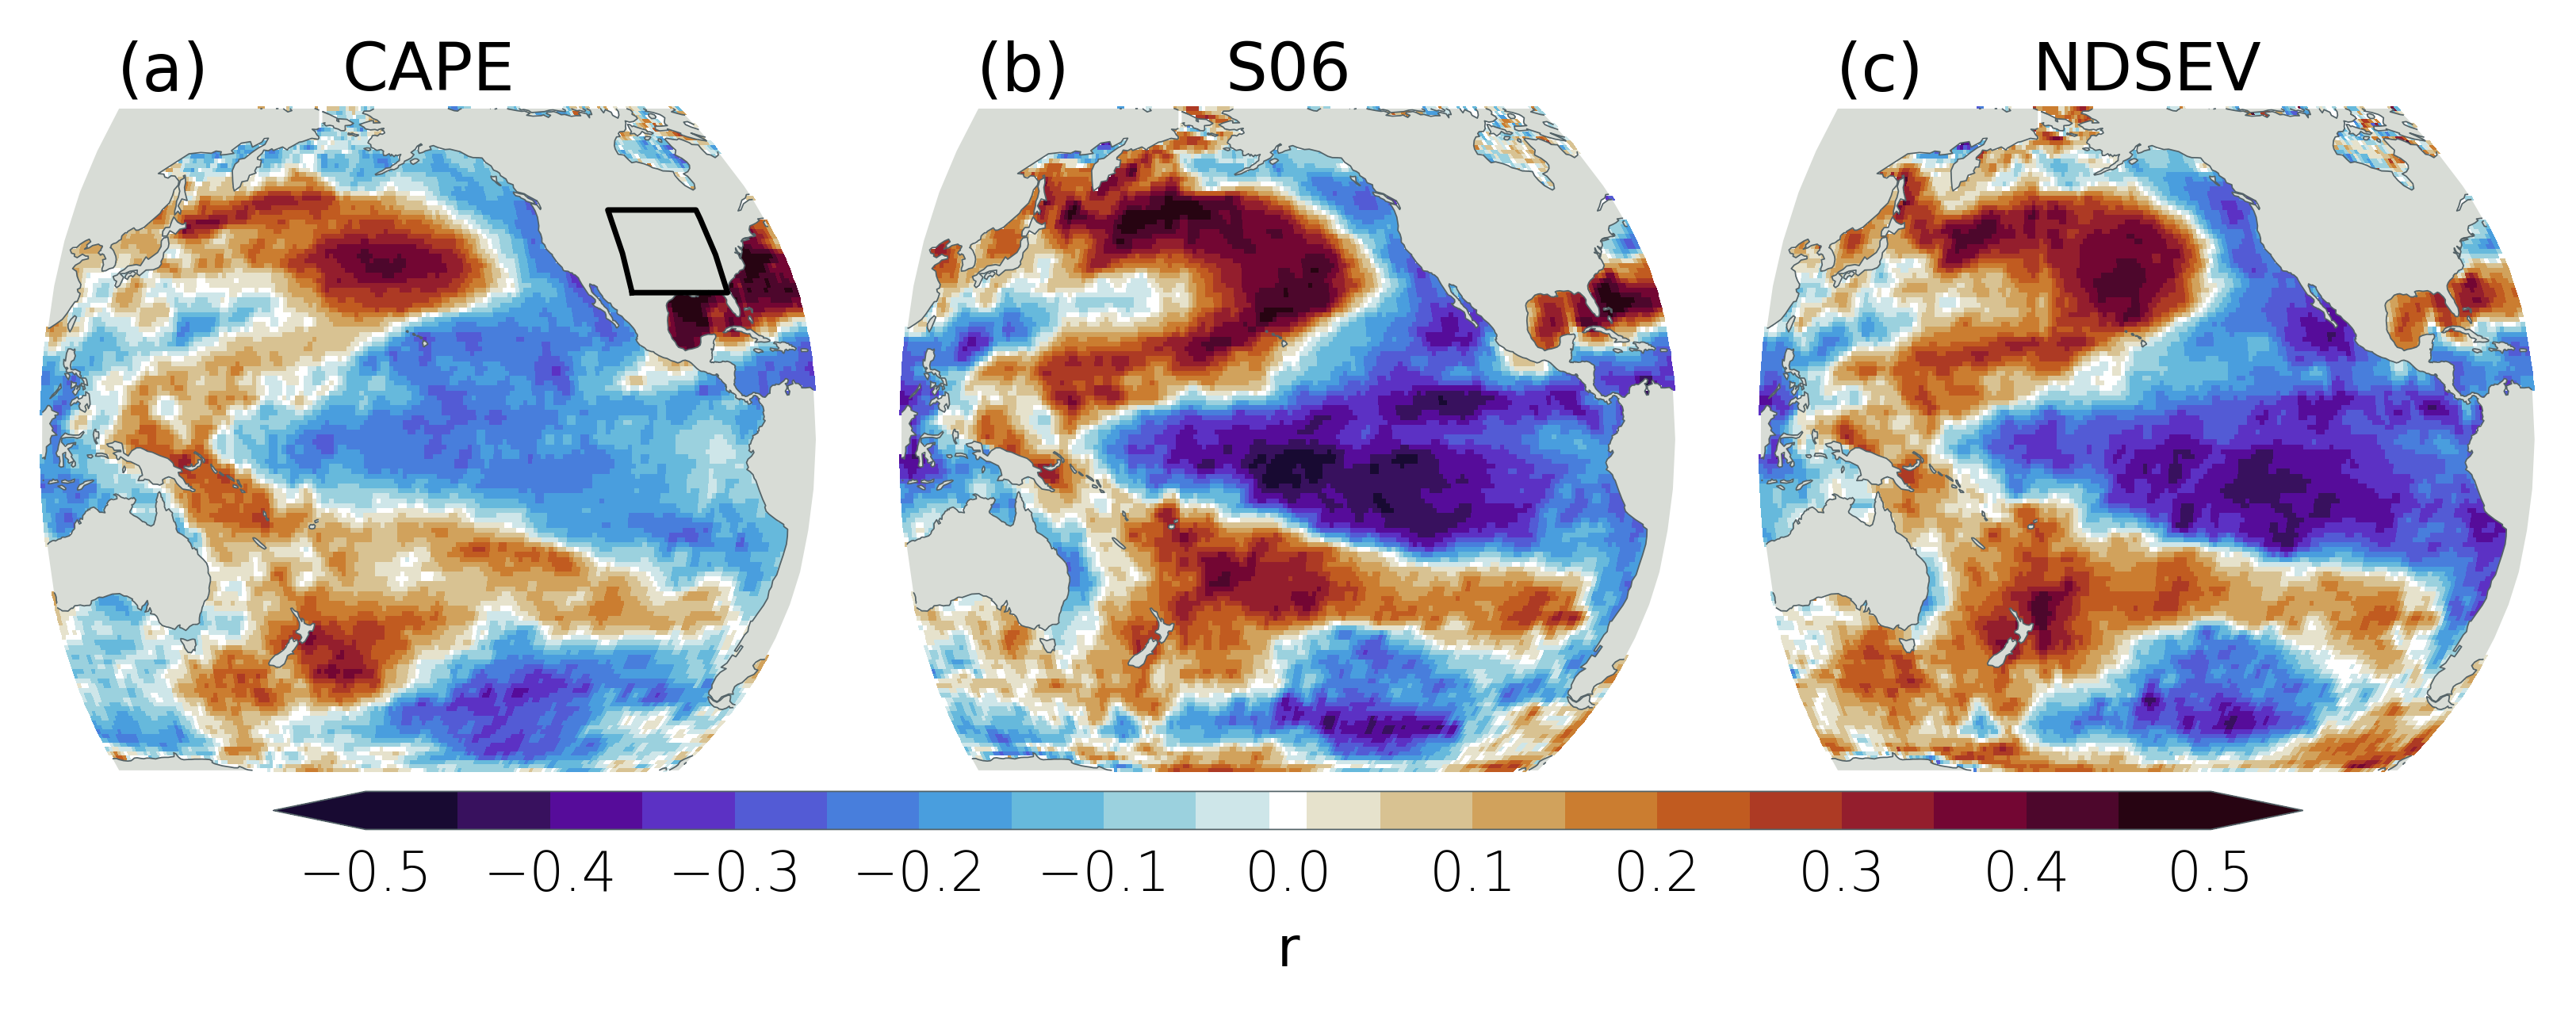

In [23]:
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

bounds = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

# SST lon/lat bounds
lons = cape_corr_sel['longitude'].values
lats = cape_corr_sel['latitude'].values
lon_min, lon_max = lons.min(), lons.max()
lat_min, lat_max = lats.min(), lats.max()

lons1 = cape_corr_sel1['longitude'].values
lats1 = cape_corr_sel1['latitude'].values
lon_min1, lon_max1 = lons1.min(), lons1.max()
lat_min1, lat_max1 = lats1.min(), lats1.max()

# Create bounding box of SST region
sst_bbox = box(lon_min, lat_min, lon_max, lat_max)
sst_bbox1 = box(lon_min1, lat_min1, lon_max1, lat_max1)

# Load land geometries from Natural Earth
land_shp = cfeature.NaturalEarthFeature('physical', 'land', '110m')
land_geoms = list(land_shp.geometries())

# Clip land geometries to SST bounding box
clipped_land = [geom.intersection(sst_bbox) for geom in land_geoms]
clipped_land1 = [geom.intersection(sst_bbox1) for geom in land_geoms]
# Remove empty geometries
clipped_land = [geom for geom in clipped_land if not geom.is_empty]
clipped_land1 = [geom for geom in clipped_land1 if not geom.is_empty]

# Create a ShapelyFeature for plotting
clipped_land_feature = ShapelyFeature(clipped_land, ccrs.PlateCarree(),
                                       facecolor='xkcd:light gray')
clipped_land_feature1 = ShapelyFeature(clipped_land1, ccrs.PlateCarree(),
                                       facecolor='xkcd:light gray')

# Get coastline geometries
coastline_shp = cfeature.NaturalEarthFeature('physical', 'coastline', '110m')
coast_geoms = list(coastline_shp.geometries())

# Clip coastlines to SST region
clipped_coast = [geom.intersection(sst_bbox) for geom in coast_geoms]
clipped_coast = [geom for geom in clipped_coast if not geom.is_empty]

clipped_coast1 = [geom.intersection(sst_bbox1) for geom in coast_geoms]
clipped_coast1 = [geom for geom in clipped_coast1 if not geom.is_empty]

# Plot clipped coastlines
clipped_coast_feature = ShapelyFeature(clipped_coast, ccrs.PlateCarree(),
                                       edgecolor='xkcd:gunmetal', facecolor='none', lw=0.25)

clipped_coast_feature1 = ShapelyFeature(clipped_coast1, ccrs.PlateCarree(),
                                       edgecolor='xkcd:gunmetal', facecolor='none', lw=0.25)

for i in range(3):
    # ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.)
    ax[i].add_feature(clipped_land_feature)
    ax[i].add_feature(clipped_land_feature1)
    ax[i].add_feature(clipped_coast_feature)
    ax[i].add_feature(clipped_coast_feature1)


ax[0].pcolormesh(cape_corr_sel['longitude'], cape_corr_sel['latitude'], cape_corr_sel, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[0].pcolormesh(cape_corr_sel1['longitude'], cape_corr_sel1['latitude'], cape_corr_sel1, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(cape_corr_sel['longitude'], cape_corr_sel['latitude'], s06_corr_sel, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[1].pcolormesh(cape_corr_sel1['longitude'], cape_corr_sel1['latitude'], s06_corr_sel1, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(cape_corr_sel['longitude'], cape_corr_sel['latitude'], ndsev_corr_sel, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[2].pcolormesh(cape_corr_sel1['longitude'], cape_corr_sel1['latitude'], ndsev_corr_sel1, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('CAPE', pad=3)
ax[1].set_title('S06', pad=3)
ax[2].set_title('NDSEV', pad=3)

ax[0].set_title('(a)', loc='left', pad=3, x=0.1)
ax[1].set_title('(b)', loc='left', pad=3, x=0.1)
ax[2].set_title('(c)', loc='left', pad=3, x=0.1)

lat_min, lat_max = 30, 47
lon_min, lon_max = pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)
rect_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
rect_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax[0].plot(rect_lons, rect_lats, color='black', lw=1, transform=ccrs.PlateCarree())

cax = plt.axes([0.1, .22, 0.8, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.set_label(r'r', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('xkcd:gunmetal')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.6, 
                    wspace=0.05, 
                    hspace=0.05)